In [1]:
import  matplotlib
%matplotlib inline
import matplotlib.pyplot as plt;
import seaborn as sns; sns.set()

import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Categorical, Beta

import torch
import numpy as np
import pandas as pd
import math
import random

# Concept

In [3]:
class Concept:
    
    def __init__(self, mult, params, max_num):
        """
        :param mult: boolean flag that is True if concept is multiple, False if concept is range
        :param params: list of params - [mult] if multiple concept, [start, end] if range concept
        """
        self.mult = mult
        self.params = params
        self.max_num = max_num
        self._numbers = self._populate_numbers()
        self._probs = np.zeros(max_num + 1)
        self._probs[self._numbers] = 1
    
    
    def _populate_numbers(self):
        """
        Fill in the number set for the concept
        """
        if self.mult:
            if (self.params[0] < 0) or (self.params[0] > self.max_num):
                raise Exception('Invalid multiple for concept.')
            
            if not isinstance(self.params[0], int):
                raise Exception('Multiple must be an integer.')
                
            numbers = np.arange(self.params[0], self.max_num + 1, self.params[0])
            return numbers
        else:
            start, end = self.params[0], self.params[1]
            
            if (start < 0) or (end > self.max_num) or (start > end):
                raise Exception('Invalid interval for concept.')
            
            if not (isinstance(start, int) and isinstance(end, int)):
                raise Exception('Start and end must be integers.')
                
            numbers = np.arange(start, end+1)
            return numbers
        
        
    def sample(self, num_samples):
        """
        Sample num_samples observations from the concept
        """
        samples = []

        for i in range(num_samples):
            sample = random.choice(self.numbers)
            samples.append(sample)

        return samples
    
    
    def __repr__(self):
        if self.mult:
            return 'Multiples of {}'.format(self.params[0], self.numbers)
        else:
            return 'Range [{}, {}]'.format(self.params[0], self.params[1], self.numbers)
    
    @property
    def numbers(self):
        return self._numbers

    @property
    def probs(self):
        return self._probs
    
    def __len__(self):
        return self._numbers.shape[0]

# Generative model

In [146]:
class NumberGame(Model):
    
    def __init__(self, max_num, mult_range_start, mult_range_end, interval_range_length, mult_weight):
        super().__init__(name='Number game')
        self.max_num = max_num
        self.mult_range_start = mult_range_start
        self.mult_range_end = mult_range_end
        self.interval_range_length = interval_range_length
        self.mult_weight = mult_weight
        self.concepts, self.concept_probs = self.generate_all_concepts()
        
    
    def _generate_multiple_concept(self, multiple):
        """
        Generates a set of all multiples of multiple from [1,... , max_num]
        :param multiple: integer from [1, max_num]
        """
        mult_concept = Concept(True, [multiple], self.max_num)
        return mult_concept
    
    
    def _generate_range_concept(self, start, end):
        """
        Generates a set of numbers from [start, ..., end] inclusive
        """
        range_concept = Concept(False, [start, end], self.max_num)
        return range_concept
    
    
    def generate_all_concepts(self):
        """
        Generate a set of all concepts as specified by parameters
        """
        concepts = []
        
        for multiple in range(self.mult_range_start, self.mult_range_end + 1):
            mult_concept = self._generate_multiple_concept(multiple)
            concepts.append(mult_concept)
            
        i = 1
        while i + self.interval_range_length <= 100:
            range_concept = self._generate_range_concept(i, i + self.interval_range_length)
            concepts.append(range_concept)
            i += 1
        
        concept_probs = np.ones(len(concepts))
        return (concepts, concept_probs)

    
    def forward(self):
        """
        Generative sampling process
        """
        concepts = self.concepts
        concept_probs = self.concept_probs
        
        is_mult_concept = int(pyprob.sample(Categorical([self.mult_weight,1])).item()) == 0
        if is_mult_concept:
            concept_probs = np.concatenate((np.ones(self.mult_range_end - self.mult_range_start + 1), np.zeros(self.max_num - self.interval_range_length)))
        else:
            concept_probs = np.concatenate((np.zeros(self.mult_range_end - self.mult_range_start + 1), np.ones(self.max_num - self.interval_range_length)))
            
        concept_index = pyprob.sample(Categorical(concept_probs))
        concept_index = int(concept_index.item())
        concept = concepts[concept_index]
        
        # define the likelihood
        likelihood = Categorical(concept.probs)

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        pyprob.observe(likelihood, name='obs1') # NOTE: observe -> denotes observable variables
        pyprob.observe(likelihood, name='obs2')
        pyprob.observe(likelihood, name='obs3')

        # return the latent quantity of interest
#         print(concept)
        return int(concept_index)
    
model = NumberGame(max_num=100, mult_range_start=2, mult_range_end=10, interval_range_length=10, mult_weight=3)
model_nn = NumberGame(max_num=100, mult_range_start=2, mult_range_end=10, interval_range_length=10, mult_weight=3)

In [147]:
model_nn.forward()

6

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:00:06 | 0d:00:00:00 | #################### | 10000/10000 | 1,600.90       


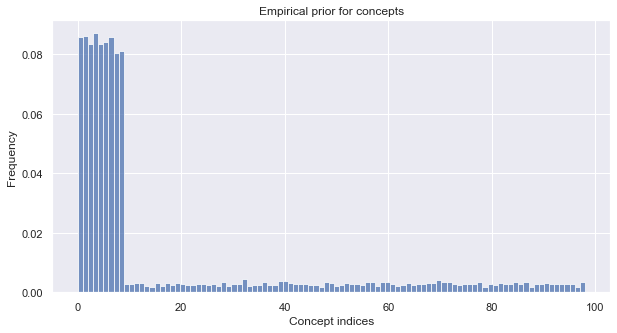

In [160]:
prior = model_nn.prior_results(num_traces=10000)
prior.plot_histogram(show=False, alpha=0.75, label='empirical prior', bins=99)
plt.title('Empirical prior for concepts')
plt.xlabel('Concept indices')
plt.savefig('images/empirical_concept_prior.png')

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 1,377.84       


[(Multiples of 4, 0.5905909263279627),
 (Range [35, 45], 0.34665600384414563),
 (Multiples of 2, 0.06275034235616536)]

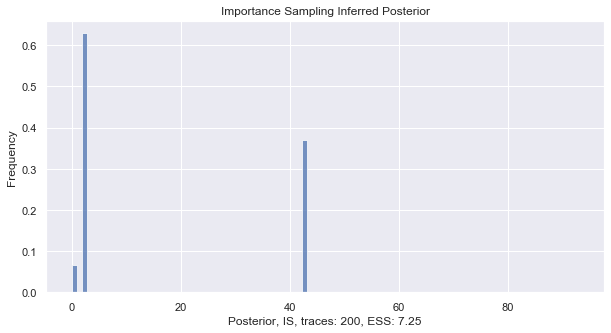

In [181]:
posterior = model.posterior_results(
                    num_traces=200, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe={'obs1': 40, 'obs2': 44, 'obs3': 36}) # assign values to the observed values
posterior.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')
plt.savefig('images/importance_sampling_inferred_posterior_200.png')
combined = posterior.combine_duplicates()
hypothesis = [(model.concepts[combined[i]], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
sorted(hypothesis, key=lambda x: x[1], reverse=True)

# Inference Compilation

In [167]:
model_nn.learn_inference_network(num_traces=10000,
                              observe_embeddings={'obs1' : {'dim' : 32},
                                                  'obs2': {'dim' : 32},
                                                  'obs3': {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable obs1: reshape not specified, using shape torch.Size([]).
Observable obs1: using embedding dim torch.Size([32]).
Observable obs1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs1: embedding depth not specified, using the default 2.
Observable obs2: reshape not specified, using shape torch.Size([]).
Observable obs2: using embedding dim torch.Size([32]).
Observable obs2: observe embedding not specified, using the default FEEDFORWARD.
Observable obs2: embedding depth not specified, using the default 2.
Observable obs3: reshape not specified, using shape torch.Size([]).
Observable obs3: using embedding dim torch.Size([32]).
Observable obs3: observe embedding not specified, using the default FEEDFORWARD.
Observable obs3: embedding depth not specified, using the default 2.
Observe embedding dimension: 96
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layer

In [409]:
print(model_nn._inference_network)

InferenceNetworkLSTM(
  (_layers_observe_embedding): ModuleDict(
    (obs1): EmbeddingFeedForward(
      (_layers): ModuleList(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=32, bias=True)
      )
    )
    (obs2): EmbeddingFeedForward(
      (_layers): ModuleList(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=32, bias=True)
      )
    )
    (obs3): EmbeddingFeedForward(
      (_layers): ModuleList(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=32, bias=True)
      )
    )
  )
  (_layers_proposal): ModuleDict(
    (30__forward__?__Categorical(len_probs:2)__1): ProposalCategoricalCategorical(
      (_ff): EmbeddingFeedForward(
        (_layers): ModuleList(
          (0): Linear(in_features=512, out_features=257, bias=True)
          (1): Linear(in_features=257, out_features=2, bias=True)
  

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 452.35       


[(Multiples of 4, 0.43898757849321224),
 (Range [36, 46], 0.1986607684162871),
 (Range [34, 44], 0.16215812140148533),
 (Multiples of 2, 0.11256149188676667),
 (Range [35, 45], 0.08763100611834623)]

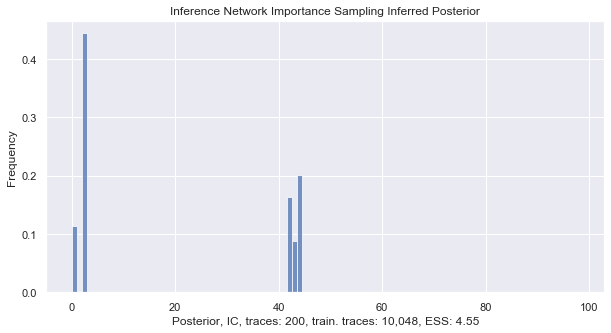

In [180]:
posterior_nn = model_nn.posterior_results(num_traces=200, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                    observe={'obs1': 40, 'obs2': 44, 'obs3': 36}) # assign values to the observed values
posterior_nn.plot_histogram(show=False, bins=99, alpha=0.75, label='inferred posterior')
plt.title('Inference Network Importance Sampling Inferred Posterior')
plt.savefig('images/nn_inferred_200.png')

combined_nn = posterior_nn.combine_duplicates()
hypothesis_nn = [(model_nn.concepts[combined_nn[i]], np.exp(combined_nn._get_log_weight(i).item())) for i in range(combined_nn._length) if np.exp(combined_nn._get_log_weight(i).item()) > 0.00001]
sorted(hypothesis_nn, key=lambda x: x[1], reverse=True)

# Compute True Probabilities

In [149]:
def compute_true_probs(prior_probs, observations, concepts):
    posteriors = []
    for i, concept in enumerate(concepts):
        posterior = prior_probs[i]
        for obs in observations:
            if obs in concept.numbers:
                posterior /= len(concept.numbers)
            else:
                posterior = 0
        posteriors.append(posterior)
    
    posteriors = np.array(posteriors)/sum(posteriors)
    
    return posteriors

In [154]:
priors = [0.75/9]*9 + [0.25/90]*90

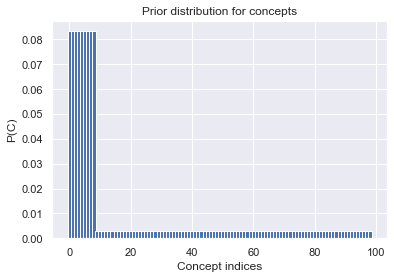

In [164]:
plt.bar(range(len(priors)), priors, width=1.2)
plt.title('Prior distribution for concepts')
plt.xlabel('Concept indices')
plt.ylabel('P(C)')
plt.savefig('images/concept_prior.png')

In [155]:
true_post = compute_true_probs(priors, [40, 44, 36], model.concepts)

In [156]:
true_post

array([0.05437314, 0.        , 0.43498509, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.17021392, 0.17021392, 0.17021392,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

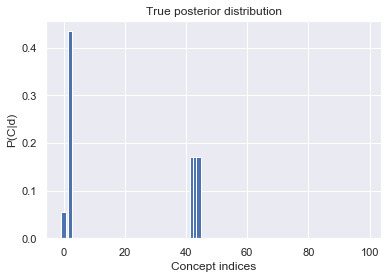

In [159]:
true_post = compute_true_probs(priors, [40, 44, 36], model.concepts)
# true_post.plot_histogram(show=False, bins=99, alpha=0.75, label='true posterior')
plt.bar(range(len(true_post)), true_post, width=1.5)
plt.title('True posterior distribution')
plt.xlabel('Concept indices')
plt.ylabel('P(C|d)')
plt.savefig('images/true_posterior.png')

# Divergence evaluation

In [262]:
from pyprob.distributions import Distribution
from torch.distributions.kl import _kl_categorical_categorical as kl

In [218]:
combined = posterior.combine_duplicates()
print(np.exp(combined._get_log_weight(0).item()))
hypothesis = [(model.concepts[combined[i]], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length)]
# sorted(hypothesis, key=lambda x: x[0].__repr__())

1.0161319613822015e-17


In [230]:
def get_emp_prob(posterior):
    combined = posterior.combine_duplicates()
    emp_probs = []
    for i in range(len(model.concepts)):
        found = False
        for j in range(combined._length):
            if model.concepts[i] == model.concepts[combined[j]]:
                emp_probs.append(np.exp(combined._get_log_weight(j).item()))
                found = True
        if not found:
            emp_probs.append(0)
    
    return emp_probs

In [396]:
def calc_divergence(p, q):
    t = np.exp(p.logits) - np.exp(q.logits)
    t[(q.probs == 0).expand_as(t)] = 0
    t[(p.probs == 0).expand_as(t)] = 0
    return abs(t.sum(-1).numpy())


In [397]:
is_emp_post = get_emp_prob(posterior)

In [398]:
csis_emp_post = get_emp_prob(posterior_nn)

In [399]:
calc_divergence(Categorical(true_post), Categorical(is_emp_post))

0.34042513

In [400]:
calc_divergence(Categorical(true_post), Categorical(csis_emp_post))

1.0281801e-06

In [401]:
def plot_divergences_importance_sampling(max_traces):
    trace_count = range(100, max_traces, 100)
    divergences = []
    
    for num_traces in range(100, max_traces, 100):
        posterior = model.posterior_results(
                    num_traces=num_traces, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe={'obs1': 40, 'obs2': 44, 'obs3': 36})
        emp_probs = get_emp_prob(posterior)
        divergence = calc_divergence(Categorical(true_post), Categorical(emp_probs))
        divergences.append(divergence)
    
    plt.plot(trace_count, divergences)
    plt.yscale('log')
    plt.title('Number of traces vs. divergence (importance sampling)')
    plt.ylabel('Divergence')
    plt.xlabel('Number of traces')
    plt.savefig('images/traces_vs_divergence_{}.png'.format(max_traces))

In [402]:
def plot_divergences_csis(max_traces):
    trace_count = range(100, max_traces, 100)
    divergences = []
    
    for num_traces in range(100, max_traces, 100):
        posterior = model_nn.posterior_results(
                    num_traces=num_traces, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                    observe={'obs1': 40, 'obs2': 44, 'obs3': 36})
        emp_probs = get_emp_prob(posterior)
        divergence = calc_divergence(Categorical(true_post), Categorical(emp_probs))
        divergences.append(divergence)
    
    plt.plot(trace_count, divergences)
    plt.yscale('log')
    plt.title('Number of traces vs. divergence (inference network)')
    plt.ylabel('Divergence')
    plt.xlabel('Number of traces')
    plt.savefig('images/traces_vs_divergence_{}.png'.format(max_traces))

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 1,179.62       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 1,624.18       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 300/300 | 1,680.84       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 400/400 | 1,619.92       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 500/500 | 1,587.71       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 600/600 | 1,684.16       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | ######

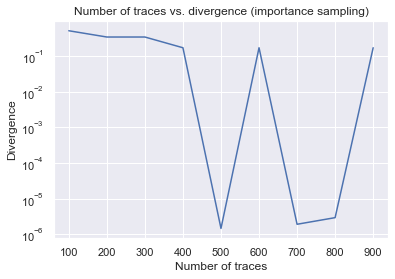

In [426]:
plot_divergences_importance_sampling(1000)

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 423.54       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 460.05       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 300/300 | 468.31       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 400/400 | 460.91       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 469.26       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 600/600 | 476.32       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | ##################

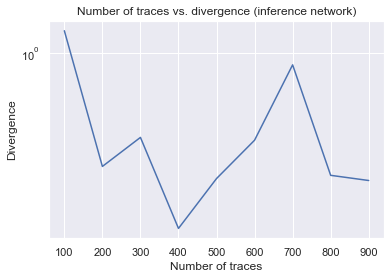

In [395]:
plot_divergences_csis(1000)

In [424]:
def plot_divergences(max_traces):
    trace_count = range(100, max_traces, 50)
    divergences_total = []
    divergences_nn_total = []
    
    for num_traces in range(100, max_traces, 50):
        divergences = []
        divergences_nn = []
        for i in range(10):
            posterior = model.posterior_results(
                        num_traces=num_traces, # the number of samples estimating the posterior
                        inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                        observe={'obs1': 40, 'obs2': 44, 'obs3': 36})
            posterior_nn = model_nn.posterior_results(
                        num_traces=num_traces, # the number of samples estimating the posterior
                        inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                        observe={'obs1': 40, 'obs2': 44, 'obs3': 36})

            emp_probs = get_emp_prob(posterior)
            emp_probs_nn = get_emp_prob(posterior_nn)
            divergence = calc_divergence(Categorical(true_post), Categorical(emp_probs))
            divergence_nn = calc_divergence(Categorical(true_post), Categorical(emp_probs_nn))
            divergences.append(divergence)
            divergences_nn.append(divergence_nn)
        divergences_total.append(np.mean(divergences))
        divergences_nn_total.append(np.mean(divergence_nn))

    plt.plot(trace_count, divergences_total, label='importance sampling')
    plt.plot(trace_count, divergences_nn_total, label='inference compilation')
    plt.yscale('log')
    plt.title('Number of traces vs. divergence')
    plt.ylabel('Divergence')
    plt.xlabel('Number of traces')
    plt.legend()
    plt.savefig('images/traces_vs_divergence_both_{}_averaged.png'.format(max_traces))

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 1,155.64       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 368.20       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 1,322.42       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 356.93       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 1,380.87       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 437.97       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | ############

0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 467.78       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 1,593.77       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 490.01       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 1,545.58       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 200/200 | 468.15       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 250/250 | 1,548.92       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 250/250 | 484.86       
Time spent  | Time remain.| Progress 

0d:00:00:00 | 0d:00:00:00 | #################### | 350/350 | 1,479.20       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 350/350 | 368.79       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 350/350 | 1,593.74       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 350/350 | 423.64       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 350/350 | 1,308.60       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 350/350 | 475.03       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 350/350 | 1,486.24       
Time spent  | Time remain.| Progres

0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 456.90       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 500/500 | 1,532.41       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 458.14       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 500/500 | 1,489.77       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 466.95       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 500/500 | 1,519.28       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 454.36       
Time spent  | Time remain.| Progress 

0d:00:00:00 | 0d:00:00:00 | #################### | 650/650 | 1,558.54       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 650/650 | 491.57       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 650/650 | 1,542.76       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 650/650 | 483.26       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 650/650 | 1,537.41       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 650/650 | 492.05       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 650/650 | 1,561.36       
Time spent  | Time remain.| Progres

0d:00:00:01 | 0d:00:00:00 | #################### | 750/750 | 487.30       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 750/750 | 1,571.59       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 750/750 | 469.64       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 750/750 | 1,415.17       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 750/750 | 476.14       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 800/800 | 1,556.42       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 800/800 | 466.72       
Time spent  | Time remain.| Progress 

0d:00:00:00 | 0d:00:00:00 | #################### | 900/900 | 1,559.48       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 900/900 | 492.02       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 900/900 | 1,586.85       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 900/900 | 501.88       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 900/900 | 1,582.82       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 900/900 | 498.27       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 900/900 | 1,565.60       
Time spent  | Time remain.| Progres

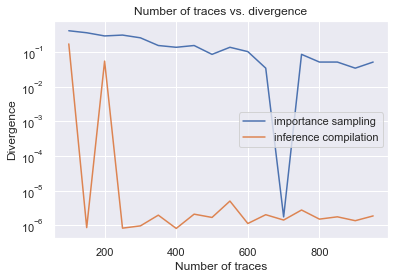

In [425]:
plot_divergences(1000)